In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
from pprint import pprint
import seaborn as sns
from statsmodels.tsa.stattools import adfuller  
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf   

In [2]:
# Reading and normalizing csv containing the btc historial prices

btc_df = pd.read_csv("exported/investing.com/Bitcoin Historical Data - Investing.com.csv", usecols = ['Date','Price'])
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df['Date'] = btc_df['Date'].dt.normalize()
btc_df = btc_df.reset_index().set_index('Date')
btc_df = btc_df.drop(['index'], axis=1)
btc_df['Price'] = btc_df['Price'].str.replace(',', '')
btc_df['Price'] = btc_df['Price'].astype('float64')
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 2021-06-26 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


Text(0.5, 1.0, 'Box plot para preço do bitcoin')

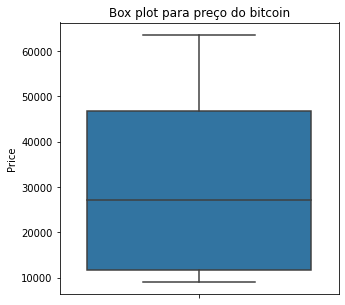

In [3]:
# Checking for outliers

plt.figure(figsize=(5, 5))
g = sns.boxplot(y=btc_df['Price'])  #realiza o plot através da biblioteca seaborn
g.set_title('Box plot para preço do bitcoin')

Text(0, 0.5, 'Preço')

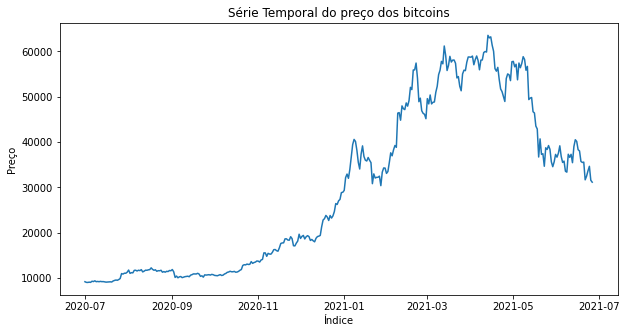

In [4]:
# Plot the Price TimeSeries
plt.figure(figsize=(10, 5))
g = sns.lineplot(x=btc_df.index,y=btc_df['Price'])
g.set_title('Série Temporal do preço dos bitcoins')
g.set_xlabel('Índice')
g.set_ylabel('Preço')

In [5]:
# Merging the btc historical price data with the sentimental analisys data

df = pd.read_csv("generated/btc_em_sentimental_analysis.csv", index_col='Date')
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)
btc_df.index = btc_df.index.tz_localize(None)
merged = pd.merge(df, btc_df, on = ['Date'], how = 'outer')

In [6]:
# Creating final csv file with Date, Score and Price columns

merged['Score'] = merged['Score'].fillna(0)
merged['Score'] = pd.to_numeric(merged['Score'])
merged['PositiveScore'] = merged['PositiveScore'].fillna(0)
merged['PositiveScore'] = pd.to_numeric(merged['PositiveScore'])
merged['NeutralScore'] = merged['NeutralScore'].fillna(0)
merged['NeutralScore'] = pd.to_numeric(merged['NeutralScore'])
merged['NegativeScore'] = merged['NegativeScore'].fillna(0)
merged['NegativeScore'] = pd.to_numeric(merged['NegativeScore'])
merged['Price'] = pd.to_numeric(merged['Price'])
merged.to_csv('generated/btc_value_em_tweets_sentimental_score.csv')

In [7]:
merged.head()

,Score,PositiveScore,NeutralScore,NegativeScore,Price
Date,,,,,
2021-06-13,0.8689,0.226,0.774,0.000,39022.9
2021-06-04,-0.4215,0.000,0.517,0.483,36851.3
2021-05-22,0.4404,0.304,0.552,0.144,37448.3
2021-05-11,0.4404,0.438,0.562,0.000,56695.7
2021-05-07,0.5859,0.444,0.556,0.000,57337.2
